# Quantification

This notebook helps quantifying the results of the various approaches implemente.
It uses the dice metric to quantify the results.
Please see the notebook: 'load_coco.ipynb' to load an image and its ground truth and use 'drawing.ipynb' to draw the scribbles on the image

In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm
from tools import *
from utils_texture import compute_texture_info, compute_segmentation, compute_probability,  create_scribble, compute_distance, plot_segmentation_and_image
from tools import dice
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
import cv2
import os 
import pickle

In [2]:
showScribble =  False
showDistanceMap = False
showSegmentation = False
NB_ITERS = 50
alpha = 30  # Distance parameter: indicates how segmentation is locally sensible to the input scribble
sigma = 30  # Smoothing parameter: indicates how segmentation depends on color
LMBD = 30  # Regularization parameter:
eps = 10e-7
USE_DIST = True
USE_COLOR = True
MARGINAL = False
color_palette = [[0, 1, 1], [1, 0, 0], [0, 0, 1], [0, 1, 0], [1, 1, 1], [0.5, 0.5, 0]]
###########################################################################################

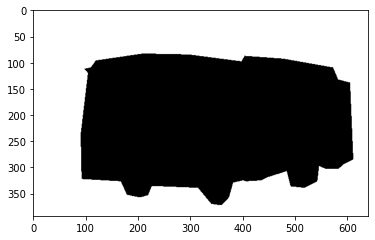

In [3]:
img_name = 'bus'
original_img = plt.imread(f'input/{img_name}.jpg')
ground_truth = np.load(f'input/{img_name}_gt.npy')
plt.imshow(ground_truth.astype('uint8'), cmap = "gray")

## Quantification performances with textures

In [4]:
for i in range(10): # we will test with 0 to 10 textures channels
    print(f'number of texture channles: {i}')
    if os.path.isfile('output/textures_perfs.pkl'):
        textures_perf = pickle.load(open('output/textures_perfs.pkl', 'rb'))
    else:
        textures_perf = dict()

    if i not in textures_perf.keys():
    
        img = compute_texture_info(original_img, number_of_texture_filters_to_use = i)
        img = img / np.max(img) * 255.
        NB_CLASSES = 2

        scribbles, X,Y,I = create_scribble(img, img_name, 'input/', showScribble, NB_CLASSES,color_palette)
        # Compute shortest path to scribble (rho)
        print('>> Computing shortest path to scribble...')
        n, m = img.shape[:2]
        dists  = compute_distance(img, X, Y, NB_CLASSES, showDistanceMap)

        print('>> Computing segmentation...')
        segmentation = compute_segmentation(img, scribbles, X, Y, I, dists, alpha, eps, sigma, USE_DIST, USE_COLOR, MARGINAL, NB_CLASSES, NB_ITERS, LMBD)
        print('... Done')

        dice_score = dice(ground_truth, segmentation)

        # add the result to perf dict

        textures_perf[i] = dice_score


number of texture channles: 0
>> Computing shortest path to scribble...
>> Computing segmentation...


 71%|███████   | 279/393 [01:28<00:36,  3.12it/s]

## Compare performances

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(list(textures_perf.keys()), list(textures_perf.values()))
plt.title('dice score against the number of texture channels used')
plt.xlabel('number of textures channels')
plt.ylabel('dice score')
plt.show()

dice score with textures: 90.02
dice score without textures: 91.84
